In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%aimport decompV
%aimport model_chol
%aimport simulation

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

import decompV, model_chol
import simulation

# No spike regression

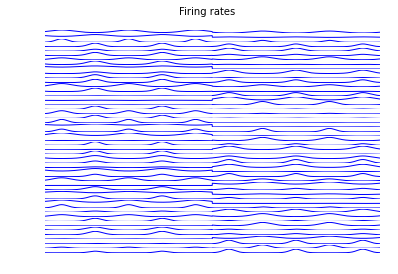

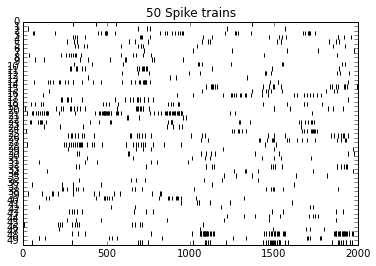

In [24]:
np.random.seed(0)

T = 2000
p = 0
L = 2
N = 50

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
x[:T // 2, 0] = high
x[T // 2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

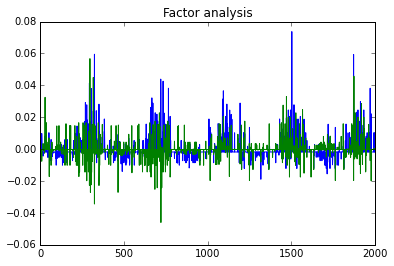

In [25]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [72]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-4
w[1] = 1e-4

from model_chol import train
%lprun -f decompV.train decompV.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-4, verbose=True)


Iteration[1]
lower bound = -16835842533.68340
increment = 83228461.8961639404
time = 0.26s
change in alpha = 0.0000000000
change in beta = 0.9999998299
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -4208968383.92803
increment = 12626874149.7553653717
time = 0.27s
change in alpha = 0.0000000000
change in beta = 0.9945746844
change in posterior mean = 0.0437851674
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -1052247554.46732
increment = 3156720829.4607110023
time = 0.27s
change in alpha = 0.0000000000
change in beta = 0.9853354750
change in posterior mean = 0.0537902660
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -263066855.46623
increment = 789180699.0010941029
time = 0.26s
change in alpha = 1.0899781114
change in beta = 0.9607944363
change in posterior mean = 0.114810


Iteration[1]
lower bound = -16835842509.38052
increment = 12003764450.3050537109
time = 0.25s
change in alpha = 0.0000000000
change in beta = 0.9999999994
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -4208967876.26044
increment = 12626874633.1200866699
time = 0.25s
change in alpha = 0.0000000000
change in beta = 0.9945826075
change in posterior mean = 0.0359964784
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -1052247473.19799
increment = 3156720403.0624465942
time = 0.26s
change in alpha = 0.0000000000
change in beta = 0.9853536617
change in posterior mean = 0.0568339954
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -263066801.21366
increment = 789180671.9843280315
time = 0.25s
change in alpha = 2.0183676721
change in beta = 0.9607678539
change in posterior mean = 0.126

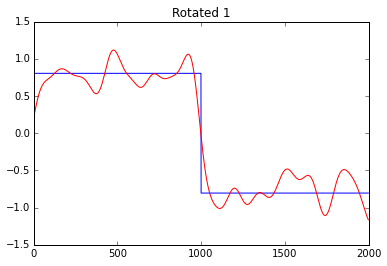

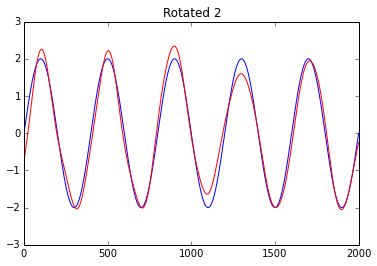

In [71]:
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = decompV.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

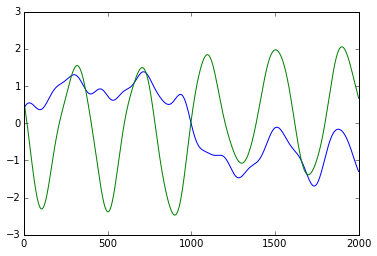

In [73]:
plot(m1)

In [45]:
np.finfo(float).eps

2.2204460492503131e-16